## Power Analysis

### SWABT:

* Describe the concept of "Power" in relation to p-value and effect size for hypothesis testing. 
* Understand and critically evaluate the factors influencing the power of an experiment.
* Perform Power calculation using Scipy and Python.
* Demonstrate the impact of sample size on statistical power using simulations.
* Demonstrate the combined effect of sample size and effect size on statistical power using simulations.


### Overview


Power analysis is an important aspect of experimental design. It allows us to determine the sample size required to detect an effect of a given size with a given degree of confidence. Conversely, it allows us to determine the probability of detecting an effect of a given size with a given level of confidence, under sample size constraints. If the probability is unacceptably low, we would be wise to alter or abandon the experiment.

The following four quantities have an intimate relationship:

* Sample size
* Effect size
* Significance level = P (Type I error) = probability of finding an effect that is not there
* **Power = 1 - P (Type II error)** = probability of finding an effect that is there

Given any three, we can determine the fourth.

In this lesson, we will consider a general-purpose simulation approach to estimating the power of an experimental design.

Consider a scenario with an expected effect size and sample size and we would like to know the associated power. For our example experiment, we will use a design with two factors: 

1. 30 participants per group
2. A ‘large’ effect size (Cohen’s d = 0.8). 

Here, we will determine the power of this test.



In [1]:
import numpy as np
import scipy.stats as stats
import pandas
import matplotlib.pyplot as plt

# No. of groups
groups = 2

# No. of samples
n = 30

# No. of simulations
sims = 10000

# Effect size = 0.8, same standard deviation for both groups
# Use two lists to store mean and sigma values
means = [0.0, 0.8] 
sigmas = [1.0, 1.0]

# Initialize a numpy array with size equal to sims and fill with nans. Store the p value for each simulation later
p_val = np.empty(sims)
p_val.fill(np.nan)

### Calculating Power

We shall now perform a large number of simulated experiments, each time calculating our test statistic (independent samples t-test, in this case) and counting the number of times we reject the null hypothesis. The power is simply the proportion of times that we are able to reject the null hypothesis (remembering that we control the population means and we know that there is a true difference).

In [2]:
#  Run a for loop for range of values in sims
for sim in range(sims):

    # Create a numpy array with size (no. of samples x no. of groups)
    data = np.empty([n, groups])
    data.fill(np.nan)

    # Simulate the data for experiment for 2 groups 
    for group in range(groups):

    # Generate normal distribution for both groups described above
        data[:, group] = np.random.normal(
                                        loc=means[group],
                                        scale=sigmas[group],
                                        size=n
                                        )
    
    # Run an independant t-test on generated distributions
    result = stats.ttest_ind(data[:, 0], data[:, 1])
    
    # Store the p value with simulation number 
    p_val[sim] = result[1]

# number of simulations where the null was rejected
rejects = np.sum(p_val < 0.05)
reject_proportion = rejects / float(sims)

# Print the reject proportion as power
print ("Power: ", reject_proportion)

# Power:  0.855

Power:  0.8539


We can see that our power to detect a large effect size with 30 participants per group in a between-subjects design is about 86%. That is, if a large effect size is truly present then we would expect to be able to reject the null hypothesis (at an alpha of 0.05) about 86% of the time.

### Calculate sample size to achieve a *given power* for a *given effect size*

Consider a scenario where you have a design and effect size in mind and would like to know what sample size you would need to achieve a particular power e.g. 80%. This is a straightforward extension of the previous example: we begin with a sample size and calculate the associated power. We then perform such a calculation repeatedly, each time increasing the sample size, until the power has reached the desired level.

The simulation code shown above can be slightly modified to improve speed of execution (i.e. the computational cost, which must be considered at all times while running large tests). Let’s make some tweaks to allow the simulations to be performed quicker. 

In the code below, we generate the simulated data all at once and then use the axis argument to `scipy.stats.ttest_ind` to perform the test. 

In [3]:

def simulation(power, cohen_d):
    
    # initialize with 20 samples per group 
    n = 10
    
    # Identify the effect size between groups
    means = [0.0, cohen_d]
    sigmas = [1.0, 1.0]

    # No. of groups
    groups = len(means)

    # Set 10000 simulations
    sims = 10000

    # power level that we would like to reach
    power_target = power

    # initialise the power for the current sample size to a small value
    power_current = 0.0
    pow_samp = []
    
    # keep iterating until desired power is obtained
    while power_current < power_target:

        data = np.empty([sims, n, groups])
        data.fill(np.nan)

        for group in range(groups):

            data[:, :, group] =  np.random.normal(
                                            loc=means[group],
                                            scale=sigmas[group],
                                            size=[sims, n]
                                             )

        result = stats.ttest_ind(
                            data[:, :, 0],
                            data[:, :, 1],
                            axis=1
                            )

        p_val = result[1]

        # Number of simulations where the null hypothesis was rejected
        rejects = np.sum(p_val < 0.05)
        
        # Calculate reject proportion
        reject_proportion = rejects/ float(sims)

        power_current =  reject_proportion

        print ("With", n,"samples per group, Power =", power_current)
        pow_samp.append([n, power_current])

        # increase the number of samples by one for the next iteration of the loop
        n += 1
    return pow_samp

Now we can set the value for required power and effect size to calculate the number of samples required to achieve the specified level of power.

With 10 samples per group, Power = 0.3985
With 11 samples per group, Power = 0.4335
With 12 samples per group, Power = 0.463
With 13 samples per group, Power = 0.5074
With 14 samples per group, Power = 0.5297
With 15 samples per group, Power = 0.5669
With 16 samples per group, Power = 0.5883
With 17 samples per group, Power = 0.6215
With 18 samples per group, Power = 0.6545
With 19 samples per group, Power = 0.6789
With 20 samples per group, Power = 0.6943
With 21 samples per group, Power = 0.7094
With 22 samples per group, Power = 0.7388
With 23 samples per group, Power = 0.7568
With 24 samples per group, Power = 0.7628
With 25 samples per group, Power = 0.7957
With 26 samples per group, Power = 0.8077
With 27 samples per group, Power = 0.818
With 28 samples per group, Power = 0.8372
With 29 samples per group, Power = 0.8432
With 30 samples per group, Power = 0.8569
With 31 samples per group, Power = 0.8716
With 32 samples per group, Power = 0.8781
With 33 samples per group, Power = 0

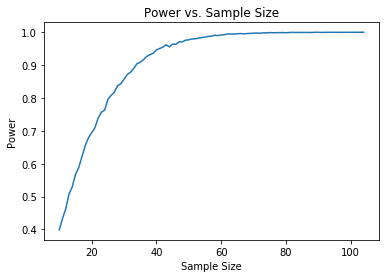

In [4]:
# Set Power and Cohen'd - Change these values and observe the effect on the outcome. 
set_power = 1
set_d = 0.8

plt.figure()
plt.title('Power vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Power')

ans = simulation(set_power, set_d)
df = pandas.DataFrame(ans, index=None)
plt.plot(df[0], df[1]) 

plt.show()


The figure shows a decelerating relationship between the number of samples in each group and the power. 

>**EXERCISE: Calculating power across varying sample and effect sizes**

>In the previous examples, we have assumed a fixed (‘large’) effect size. However, perhaps we want to investigate how power changes with both effect size and sample size. This is again a straightforward extension of the previous example. 

>1. Generate samples with sizes ranging from 10 to 50 per group
2. Set effect size from less than small (i.e. 0.2) to slightly bigger than large (0.8)
3. set number of simulations to 10000
4. Use nested For loop i.e. for all chosen effect sizes,for all chosen sample sizes, for all groups (i.e. 2) - run the 2 sample independant test and store power, chosen sample size and effect size
5. Visualize your data in a meaningful way to communicate results 

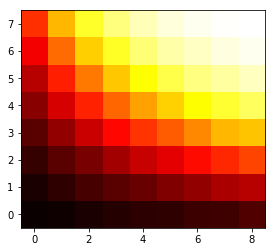

In [5]:
import numpy as np

import scipy.stats

# Set samples sizes from 10 per group up to 50 per group in steps of 5
samples_per_group = np.arange(10, 51, 5)


# Total number of samples to try out 
n_samples_per_group = len(samples_per_group)

# span the range from a bit less than a 'small' effect size to a bit bigger
# than a 'large' effect size
effect_sizes = np.arange(0.2, 0.91, 0.1)
n_effect_sizes = len(effect_sizes)


# Create an empty NumPy array with size = number of samples per group x n_effect_sizes to store power values
power = np.empty([n_effect_sizes, n_samples_per_group])
power.fill(np.nan)

# number of simulations
sims = 10000

for effect_size in range(n_effect_sizes):

    group_means = [0.0, effect_sizes[effect_size]]
    group_sigmas = [1.0, 1.0]

    groups = len(group_means)

    for sample_size in range(n_samples_per_group):

        n_per_group = samples_per_group[sample_size]

        data = np.empty([sims, n_per_group, groups])
        data.fill(np.nan)

        for group in range(groups):

            data[:, :, group] = np.random.normal(
                                            loc=group_means[group],
                                            scale=group_sigmas[group],
                                            size=[sims, n_per_group]
                                                )

        result = scipy.stats.ttest_ind(
                                data[:, :, 0],
                                data[:, :, 1],
                                axis=1
                                    )

        p_value = result[1]

        # number of simulations where the null was rejected
        rejects = np.sum(p_value < 0.05)

        reject_proportion = rejects / float(sims)

        power[effect_size, sample_size] = reject_proportion

# Display the results as a heatmap
plt.imshow(power, cmap='hot',  origin = 'lower')
plt.show()

we can see that the power for a given combination of effect size and sample size per group is represented by the luminance of the relevant cell. 

### Conclusion: 

In this lesson, we recieved an understanding around the idea of "statistical power" and how sample size, p_value and effect size impact the power of an experiment. We ran a simulation to determine the sample size that would provide a given value of power. In the second simulation, we saw the combined effect of sample size and effect size on the power. We can conclude this lesson with the ideas that a) Statistical power increases as we increase the sample size and b) with a small effect size, we require a large number of samples to achieve required power and vice versa. 